In [1]:

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from mlxtend.evaluate import bias_variance_decomp
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os, csv
import sys
sys.path.insert(0, '..')
from text_cluster.data_clean import get_dataframe_from_file


from sklearn.model_selection import StratifiedKFold


from sklearn.model_selection import StratifiedKFold
import operator




In [2]:
df = get_dataframe_from_file("../cleaned_data_combined.csv", "../text_cluster")
# pd.read_csv("../cleaned_output.csv")
df.dropna(inplace=True)

In [3]:
X = df.drop(columns=['Label']).to_numpy()

y = df['Label'].to_numpy()
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [4]:
# 60% for training and 20% validation, 20% for testing TODO: do we want to adjust this
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42, stratify=y_train_valid)

In [5]:
# Output data set splits
mapping = {
    'X_train': X_train,
    'y_train': y_train,
    'X_valid': X_valid,
    'y_valid': y_valid,
    'X_test': X_test,
    'y_test': y_test
}
# for name, data in mapping.items():
#     pd.DataFrame(data).to_csv(f'dataset/{name}.csv', index=False)

In [11]:
mlp_param_dist = {
    'hidden_layer_sizes': [(30,), (40,), (50,), (60,), (75,), (100,), (20, 20), (20, 30), (30,30), (40,40), (40,50), (50,50), (75, 75), (100, 100)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': loguniform(1e-4, 0.1), 
    'learning_rate_init': loguniform(1e-4, 1e-2),
    'early_stopping': [True],
    'n_iter_no_change': [10, 25, 50], 
    'max_iter': [500]
}

bagging_param_dist = {
    'estimator__hidden_layer_sizes': [(30,), (40,), (50,), (60,), (75,), (100,), (20, 20), (20, 30), (30,30), (40,40), (40,50), (50,50), (75, 75), (100, 100)],
    'estimator__activation': ['relu'],
    'estimator__solver': ['adam'], 
    'estimator__alpha': loguniform(1e-4, 1.0),
    'estimator__learning_rate_init': loguniform(1e-4, 1e-2),
    'estimator__n_iter_no_change': [10, 25, 50],
    'estimator__max_iter': [300], 

    # Bagging specific parameters
    'n_estimators': randint(10, 51), # Number of base estimators (10 to 50)
    'max_samples': [0.7, 0.8, 0.9, 1.0], # Fraction of samples for each estimator
}


def tune_mlp_classifier(X_train_valid, y_train_valid, n_iter=50, cv=5, random_state=42):
    """
    Tunes MLPClassifier using RandomizedSearchCV.

    Args:
        X_train_valid: Combined training and validation features.
        y_train_valid: Combined training and validation labels.
        n_iter: Number of parameter settings to sample.
        cv: Number of cross-validation folds.
        random_state: Random seed for reproducibility.

    Returns:
        best_estimator: The best MLPClassifier found.
        best_params: The best parameter dictionary found.
    """
    print(f"--- Tuning MLPClassifier (n_iter={n_iter}, cv={cv}) ---")
    # Base MLP model
    base_mlp = MLPClassifier(random_state=random_state, early_stopping=True, validation_fraction=0.2)


    stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

    random_search = RandomizedSearchCV(
        estimator=base_mlp,
        param_distributions=mlp_param_dist,
        n_iter=n_iter,
        cv=stratified_cv,
        scoring='accuracy', 
        n_jobs=-1,  #change this if u want (-1) for all cores
        random_state=random_state,
        verbose=1,
        refit=True
    )

    random_search.fit(X_train_valid, y_train_valid)

    print(f"Best MLP Score (CV Accuracy): {random_search.best_score_:.4f}")
    print("Best MLP Parameters:")
    print(random_search.best_params_)

    # --- Extract Top N Results ---
    cv_results = random_search.cv_results_
    results_list = sorted(
        zip(cv_results['mean_test_score'], cv_results['params']),
        key=operator.itemgetter(0), # Sort by score (index 0)
        reverse=True # Highest score first
    )
    top_n_results = results_list[:5]

    print(f"\n--- Top {5} MLP Configurations (CV Score, Params) ---")
    for i, (score, params) in enumerate(top_n_results):
         print(f"  Rank {i+1}: Score={score:.4f}, Params={params}")

    return random_search.best_estimator_, random_search.best_params_
    


def tune_bagging_classifier(X_train_valid, y_train_valid, n_iter=30, cv=5, random_state=42):
    """
    Tunes BaggingClassifier (with MLP base estimator) using RandomizedSearchCV.
    Returs
        best_estimator: The best BaggingClassifier found.
        best_params: The best parameter dictionary found.
    """
    print(f"--- Tuning BaggingClassifier (n_iter={n_iter}, cv={cv}) ---")

    base_mlp_for_bagging = MLPClassifier(random_state=random_state, early_stopping=True, validation_fraction=0.2) 

    # Base Bagging model
    base_bagging = BaggingClassifier(
        estimator=base_mlp_for_bagging,
        random_state=random_state,
        n_jobs=8,

    )

    stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    random_search = RandomizedSearchCV(
        estimator=base_bagging,
        param_distributions=bagging_param_dist,
        n_iter=n_iter,
        cv=stratified_cv,
        scoring='accuracy',
        n_jobs=-1, #change this if u want (-1) for all cores
        random_state=random_state,
        verbose=1,
        refit=True
    )

    random_search.fit(X_train_valid, y_train_valid)

    print(f"Best Bagging Score (CV Accuracy): {random_search.best_score_:.4f}")
    print("Best Bagging Parameters:")
    best_params_formatted = {k: v for k, v in random_search.best_params_.items()}
    print(best_params_formatted)

    cv_results = random_search.cv_results_
    results_list = sorted(
        zip(cv_results['mean_test_score'], cv_results['params']),
        key=operator.itemgetter(0), # Sort by score
        reverse=True # Highest score first
    )
    top_n_results = results_list[:5]

    print(f"\n--- Top {5} Bagging Configurations (CV Score, Params) ---")
    for i, (score, params) in enumerate(top_n_results):
         
         print(f"  Rank {i+1}: Score={score:.4f}, Params={params}")


    # Important: The returned best_estimator already has the best base estimator params set
    return random_search.best_estimator_, random_search.best_params_

In [12]:

# Train MLP Classifier
mlp = MLPClassifier(random_state=1, n_iter_no_change=100, early_stopping=True)
mlp.fit(X_train, y_train)


# Train bagged MLP Classifier
bagging = BaggingClassifier(mlp, n_estimators=10, max_samples=0.8, random_state=1, verbose=0)
bagging.fit(X_train, y_train)

c:\Users\rafay\Documents\ml\ML_Challenge\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rafay\Documents\ml\ML_Challenge\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rafay\Documents\ml\ML_Challenge\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rafay\Documents\ml\ML_Challenge\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
 

BaggingClassifier(estimator=MLPClassifier(early_stopping=True,
                                          n_iter_no_change=100,
                                          random_state=1),
                  max_samples=0.8, random_state=1)

In [13]:
# Normalize the data

scaler = StandardScaler()
normalizer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), [0, 1 ,2])
    ],
    remainder='passthrough'  # Leave other columns unchanged
)
X_train_norm = normalizer.fit_transform(X_train)
X_valid_norm = normalizer.transform(X_valid)
X_test_norm = normalizer.transform(X_test)

# Train MLP Classifier with normalized data
nmlp = MLPClassifier(random_state=1, n_iter_no_change=100, early_stopping=True)
nmlp.fit(X_train_norm, y_train)

# Train bagged MLP Classifier with normalized data
normBagging = BaggingClassifier(nmlp, n_estimators=10, max_samples=0.8, random_state=1)
normBagging.fit(X_train_norm, y_train)



#Training the tuning models
X_train_valid_norm = normalizer.fit_transform(X_train_valid)
X_test_norm = normalizer.transform(X_test)


N_ITER_MLP = 50
N_ITER_BAGGING = 30


best_mlp, best_mlp_params = tune_mlp_classifier(X_train_valid, y_train_valid, n_iter=N_ITER_MLP)
best_bagging, best_bagging_params = tune_bagging_classifier(X_train_valid, y_train_valid, n_iter=N_ITER_BAGGING)

# Normalized
best_nmlp, best_nmlp_params = tune_mlp_classifier(X_train_valid_norm, y_train_valid, n_iter=N_ITER_MLP)
best_normBagging, best_normBagging_params = tune_bagging_classifier(X_train_valid_norm, y_train_valid, n_iter=N_ITER_BAGGING)



c:\Users\rafay\Documents\ml\ML_Challenge\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rafay\Documents\ml\ML_Challenge\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rafay\Documents\ml\ML_Challenge\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rafay\Documents\ml\ML_Challenge\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
 

--- Tuning MLPClassifier (n_iter=50, cv=5) ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best MLP Score (CV Accuracy): 0.8760
Best MLP Parameters:
{'activation': 'relu', 'alpha': np.float64(0.00012414804282743965), 'early_stopping': True, 'hidden_layer_sizes': (40,), 'learning_rate_init': np.float64(0.0035503048581283078), 'max_iter': 500, 'n_iter_no_change': 25, 'solver': 'adam'}

--- Top 5 MLP Configurations (CV Score, Params) ---
  Rank 1: Score=0.8760, Params={'activation': 'relu', 'alpha': np.float64(0.00012414804282743965), 'early_stopping': True, 'hidden_layer_sizes': (40,), 'learning_rate_init': np.float64(0.0035503048581283078), 'max_iter': 500, 'n_iter_no_change': 25, 'solver': 'adam'}
  Rank 2: Score=0.8745, Params={'activation': 'relu', 'alpha': np.float64(0.09845129999868124), 'early_stopping': True, 'hidden_layer_sizes': (40, 50), 'learning_rate_init': np.float64(0.001656260589333597), 'max_iter': 500, 'n_iter_no_change': 25, 'solver': 'adam'}
  Rank 3

In [19]:
def print_bias_variance_decomp(X_train, y_train, X_test, y_test):    
    expected_loss, bias, var = bias_variance_decomp(mlp,
                                                                X_train, y_train, 
                                                                X_test, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=42)
    expected_loss_bagged, bias_bagged, var_bagged = bias_variance_decomp(bagging,
                                                                X_train, y_train, 
                                                                X_test, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=42)
    expected_loss_norm, bias_norm, var_norm = bias_variance_decomp(nmlp,
                                                                X_train_norm, y_train, 
                                                                X_test_norm, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=42)
    expected_loss_bagged_norm, bias_bagged_norm, var_bagged_norm = bias_variance_decomp(normBagging,
                                                                X_train_norm, y_train, 
                                                                X_test_norm, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=42)
    tuned_expected_loss, tuned_bias, tuned_var = bias_variance_decomp(best_mlp,
                                                                X_train, y_train, 
                                                                X_test, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=42)
    tuned_expected_loss_bagged, tuned_bias_bagged, tuned_var_bagged = bias_variance_decomp(best_bagging,
                                                                X_train, y_train, 
                                                                X_test, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=42)
    tuned_expected_loss_norm, tuned_bias_norm, tuned_var_norm = bias_variance_decomp(best_nmlp,
                                                                X_train_norm, y_train, 
                                                                X_test_norm, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=42)
    tuned_expected_loss_bagged_norm, tuned_bias_bagged_norm, tuned_var_bagged_norm = bias_variance_decomp(best_normBagging,
                                                                X_train_norm, y_train, 
                                                                X_test_norm, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=42)

    print("Bias-Variance Decomposition Results")
    print("===================================")
    print(f"{'Model':<25} {'Expected Loss':<15} {'Bias':<15} {'Variance':<15}")
    print("-" * 70)
    print(f"{'MLP':<25} {expected_loss:.4f}{' '*10} {bias:.4f}{' '*10} {var:.4f}")
    print(f"{'Bagging MLP':<25} {expected_loss_bagged:.4f}{' '*10} {bias_bagged:.4f}{' '*10} {var_bagged:.4f}")
    print(f"{'Normalized MLP':<25} {expected_loss_norm:.4f}{' '*10} {bias_norm:.4f}{' '*10} {var_norm:.4f}")
    print(f"{'Normalized Bagging MLP':<25} {expected_loss_bagged_norm:.4f}{' '*10} {bias_bagged_norm:.4f}{' '*10} {var_bagged_norm:.4f}")
    print(f"{'Tuned MLP':<25} {tuned_expected_loss:.4f}{' '*10} {tuned_bias:.4f}{' '*10} {tuned_var:.4f}")
    print(f"{'Tuned Bagging MLP':<25} {tuned_expected_loss_bagged:.4f}{' '*10} {tuned_bias_bagged:.4f}{' '*10} {tuned_var_bagged:.4f}")
    print(f"{'Tuned Normalized MLP':<25} {tuned_expected_loss_norm:.4f}{' '*10} {tuned_bias_norm:.4f}{' '*10} {tuned_var_norm:.4f}")
    print(f"{'Tuned Normalized Bagging MLP':<25} {tuned_expected_loss_bagged_norm:.4f}{' '*10} {tuned_bias_bagged_norm:.4f}{' '*10} {tuned_var_bagged_norm:.4f}")

print_bias_variance_decomp(X_train, y_train, X_test, y_test)

c:\Users\rafay\Documents\ml\ML_Challenge\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rafay\Documents\ml\ML_Challenge\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rafay\Documents\ml\ML_Challenge\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rafay\Documents\ml\ML_Challenge\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
 

Bias-Variance Decomposition Results
Model                     Expected Loss   Bias            Variance       
----------------------------------------------------------------------
MLP                       0.1391           0.1216           0.0634
Bagging MLP               0.1397           0.1307           0.0552
Normalized MLP            0.1391           0.1216           0.0634
Normalized Bagging MLP    0.1397           0.1307           0.0552
Tuned MLP                 0.1438           0.1246           0.0717
Tuned Bagging MLP         0.1334           0.1216           0.0521
Tuned Normalized MLP      0.1401           0.1064           0.0766
Tuned Normalized Bagging MLP 0.1395           0.1307           0.0558


In [14]:
def export_model(model: MLPClassifier, filename: str, is_bagged: bool = False) -> None:
    """
    Save the bagged model. Note a bagged model is a collection of models, so we need to save each 
    one. This will also result different code for inference
    """
    if is_bagged:
        params = {}
        for i, estimator in enumerate(model.estimators_):
            for j in range(len(estimator.coefs_)):
                params[f'estimator_{i}_weights_{j}'] = estimator.coefs_[j]
                params[f'estimator_{i}_intercepts_{j}'] = estimator.intercepts_[j]
        params['num_estimators'] = len(model.estimators_)
        params['num_layers'] = len(model.estimators_[0].coefs_)
        params['classes'] = model.classes_
        np.savez(filename, **params)
    else:
        params = {f'weights_{i}': coef for i, coef in enumerate(model.coefs_)}
        params.update({f'biases_{i}': intercept for i, intercept in enumerate(model.intercepts_)})
        params['classes'] = model.classes_
        np.savez(filename, **params)

In [15]:
# Export the models
export_model(mlp, 'models_tunned/mlp_model.npz')
export_model(bagging, 'models_tunned/bagged_model.npz', is_bagged=True)
export_model(nmlp, 'models_tunned/normMlp_model.npz')
export_model(normBagging, 'models_tunned/normBagged_model.npz', is_bagged=True)
export_model(best_mlp, 'models_tunned/best_mlp_model.npz')
export_model(best_bagging, 'models_tunned/best_bagged_model.npz', is_bagged=True)
export_model(best_nmlp, 'models_tunned/best_normMlp_model.npz')
export_model(best_normBagging, 'models_tunned/best_normBagged_model.npz', is_bagged=True)


In [16]:
def score_and_export_results(model: MLPClassifier, X_train: pd.DataFrame, y_train: pd.Series, 
                             X_valid: pd.DataFrame, y_valid: pd.Series,
                             X_test: pd.DataFrame, y_test: pd.Series,
                             model_name: str, 
                             file_name: str) -> None:
    """
    Score the model and save the results of the model to file_name.
    """
    train_score = model.score(X_train, y_train)
    valid_score = model.score(X_valid, y_valid)
    test_score = model.score(X_test, y_test)
    print(f"Model: {model_name}")
    print(f"Training Score: {train_score:.4f}")
    print(f"Validation Score: {valid_score:.4f}")
    print(f"Test Score: {test_score:.4f}\n")
    
    params = {
        "Model": model_name,
        "Training Score": train_score,
        "Validation Score": valid_score,
        "hidden_layer_sizes": "",
        "activation": "",
        "solver": "",
        "alpha": "",
        "learning_rate_init": "",
        "n_iter_no_change": "",
        "n_estimators": "",
        "max_samples": ""
    }
    
                
    base_model = model
    if isinstance(model, BaggingClassifier):
        base_model = model.estimator_ # Access base estimator
        params["n_estimators"] = model.n_estimators
        params["max_samples"] = model.max_samples

    if isinstance(base_model, MLPClassifier):
        params["hidden_layer_sizes"] = str(base_model.hidden_layer_sizes)
        params["activation"] = base_model.activation
        params["solver"] = base_model.solver
        params["alpha"] = base_model.alpha
        params["learning_rate_init"] = base_model.learning_rate_init
        if hasattr(base_model, 'learning_rate'): # Check if attribute exists
             params["learning_rate"] = base_model.learning_rate
        if hasattr(base_model, 'n_iter_no_change'):
             params["n_iter_no_change"] = base_model.n_iter_no_change

    fieldnames = list(params.keys())
    # Write to CSV
    file_exists = os.path.isfile(file_name)
    with open(file_name, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        writer.writerows([params])

In [17]:
models = {
    "Base": (mlp, X_valid, y_valid, X_train, y_train, X_test, y_test),
    "Bagging": (bagging, X_valid, y_valid, X_train, y_train, X_test, y_test),
    "Normalized": (nmlp, X_valid_norm, y_valid, X_train_norm, y_train, X_test_norm, y_test),
    "Normalized Bagging": (normBagging, X_valid_norm, y_valid, X_train_norm, y_train, X_test_norm, y_test),
    "Tuned Base": (best_mlp, X_valid, y_valid, X_train, y_train, X_test, y_test),
    "Tuned Bagging": (best_bagging, X_valid, y_valid, X_train, y_train, X_test, y_test),
    "Tuned Normalized": (best_nmlp, X_valid_norm, y_valid, X_train_norm, y_train, X_test_norm, y_test),
    "Tuned Normalized Bagging": (best_normBagging, X_valid_norm, y_valid, X_train_norm, y_train, X_test_norm, y_test),
}

for name, (model, X_valid, y_valid, X_train, y_train, X_test, y_test) in models.items():
    score_and_export_results(model, X_train, y_train, X_valid, y_valid, X_test, y_test, name, "model_results.csv")

Model: Base
Training Score: 0.9192
Validation Score: 0.8859
Test Score: 0.8693

Model: Bagging
Training Score: 0.9325
Validation Score: 0.9011
Test Score: 0.8754

Model: Normalized
Training Score: 0.9363
Validation Score: 0.8935
Test Score: 0.8723

Model: Normalized Bagging
Training Score: 0.9411
Validation Score: 0.8973
Test Score: 0.8663

Model: Tuned Base
Training Score: 0.9411
Validation Score: 0.9392
Test Score: 0.8754

Model: Tuned Bagging
Training Score: 0.9411
Validation Score: 0.9468
Test Score: 0.8784

Model: Tuned Normalized
Training Score: 0.9477
Validation Score: 0.9544
Test Score: 0.8693

Model: Tuned Normalized Bagging
Training Score: 0.9449
Validation Score: 0.9620
Test Score: 0.8815



              precision    recall  f1-score   support

       Pizza       0.89      0.89      0.89        88
    Shawarma       0.86      0.89      0.87        88
       Sushi       0.92      0.89      0.90        87

    accuracy                           0.89       263
   macro avg       0.89      0.89      0.89       263
weighted avg       0.89      0.89      0.89       263

              precision    recall  f1-score   support

       Pizza       0.96      0.90      0.93        88
    Shawarma       0.90      0.91      0.90        88
       Sushi       0.88      0.93      0.91        87

    accuracy                           0.91       263
   macro avg       0.91      0.91      0.91       263
weighted avg       0.91      0.91      0.91       263

              precision    recall  f1-score   support

       Pizza       0.92      0.90      0.91        88
    Shawarma       0.87      0.91      0.89        88
       Sushi       0.91      0.89      0.90        87

    accuracy        

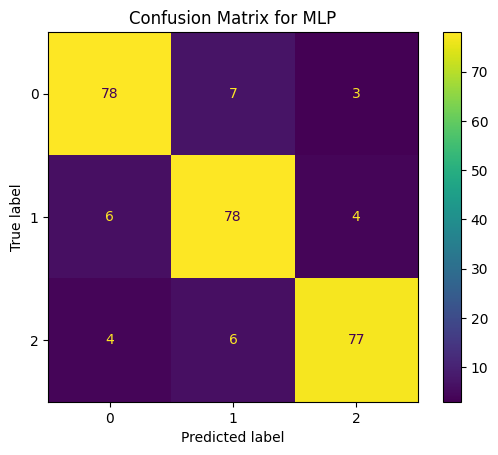

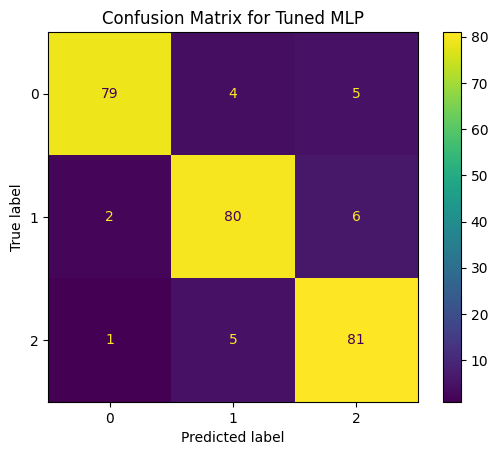

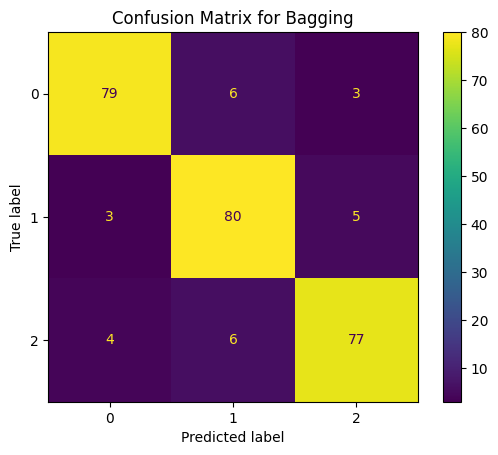

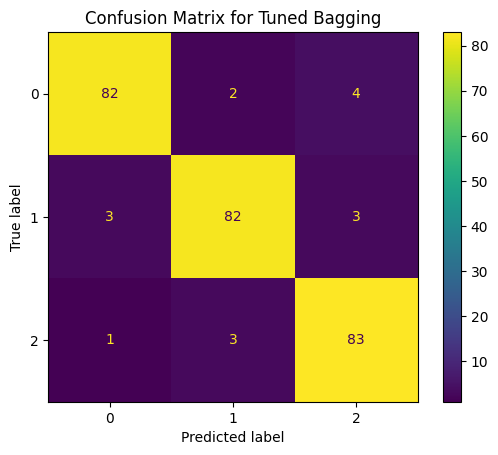

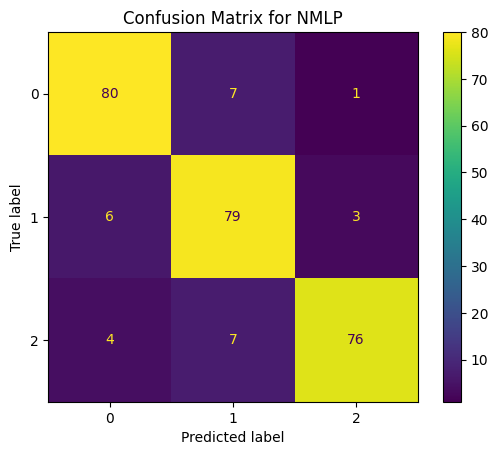

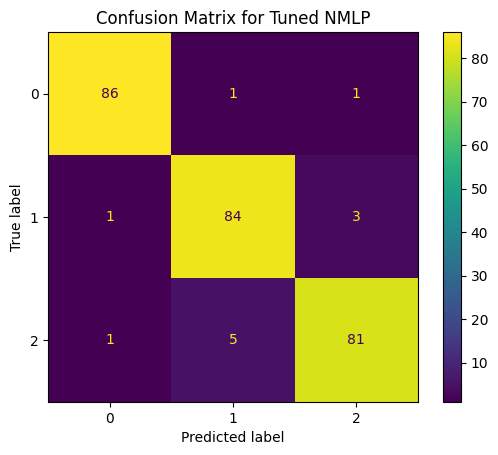

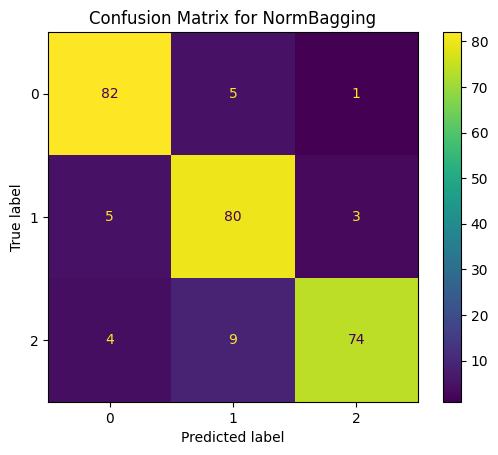

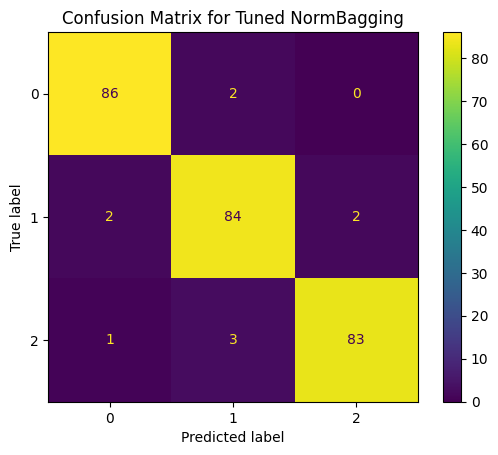

In [18]:
# predictions = bagging.predict(X_valid)

# print(classification_report(y_valid, predictions, target_names=encoder.classes_))


def plot_confusion_matrix(X, t, lr, group = "Everyone"):
    """
    Use the sklearn model "lr" to make predictions for the data "X",
    then compare the prediction with the target "t" to plot the confusion matrix.

    Moreover, this function prints the accuracy, precision and recall
    """
    cm = confusion_matrix(t, lr.predict(X))
    print(classification_report(t, lr.predict(X), target_names=encoder.classes_))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
    
    disp.plot()
    # tn, fp, fn, tp = cm.ravel()
    # print("Confusion Matrix: ", np.array([[tp, fp], [fn, tn]]))
    # print("Accuracy: ", ((tp + tn) / (tp + fp + fn + tn)))
    # print("Precision: ", (tp / (tp + fp)))
    # print("Recall: ", (tp / (tp + fn)))
    plt.title(f"Confusion Matrix for {group}")

    # plt.show()
    

# print(confusion_matrix(y_valid, predictions, labels=encoder.transform(encoder.classes_)))

plot_confusion_matrix(X_valid, y_valid, mlp, group="MLP")
plot_confusion_matrix(X_valid, y_valid, best_mlp, group="Tuned MLP")
plot_confusion_matrix(X_valid, y_valid, bagging, group="Bagging")
plot_confusion_matrix(X_valid, y_valid, best_bagging, group="Tuned Bagging")
plot_confusion_matrix(X_valid, y_valid, nmlp, group="NMLP")
plot_confusion_matrix(X_valid, y_valid, best_nmlp, group="Tuned NMLP")
plot_confusion_matrix(X_valid, y_valid, normBagging, group="NormBagging")
plot_confusion_matrix(X_valid, y_valid, best_normBagging, group="Tuned NormBagging")


              precision    recall  f1-score   support

       Pizza       0.84      0.85      0.85       109
    Shawarma       0.81      0.85      0.83       110
       Sushi       0.87      0.81      0.84       110

    accuracy                           0.84       329
   macro avg       0.84      0.84      0.84       329
weighted avg       0.84      0.84      0.84       329

              precision    recall  f1-score   support

       Pizza       0.83      0.89      0.86       109
    Shawarma       0.86      0.84      0.85       110
       Sushi       0.87      0.83      0.85       110

    accuracy                           0.85       329
   macro avg       0.85      0.85      0.85       329
weighted avg       0.85      0.85      0.85       329

              precision    recall  f1-score   support

       Pizza       0.83      0.90      0.86       109
    Shawarma       0.86      0.86      0.86       110
       Sushi       0.91      0.83      0.87       110

    accuracy        

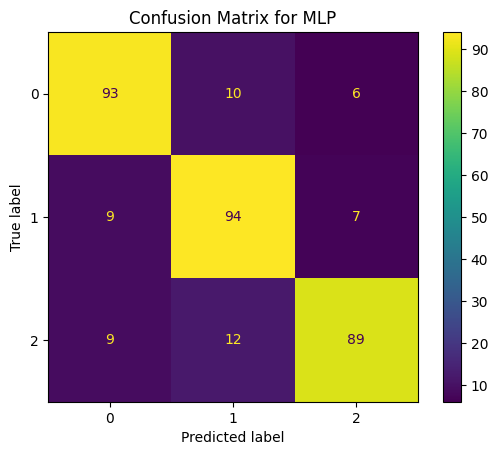

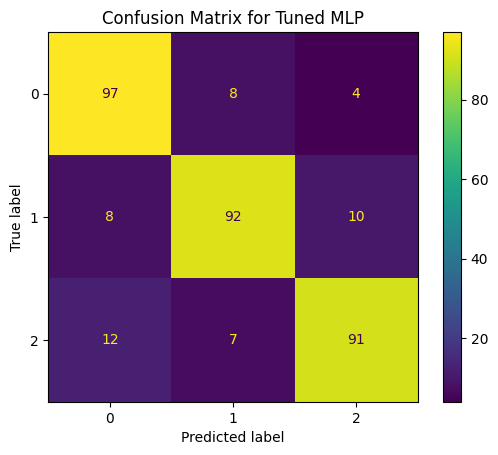

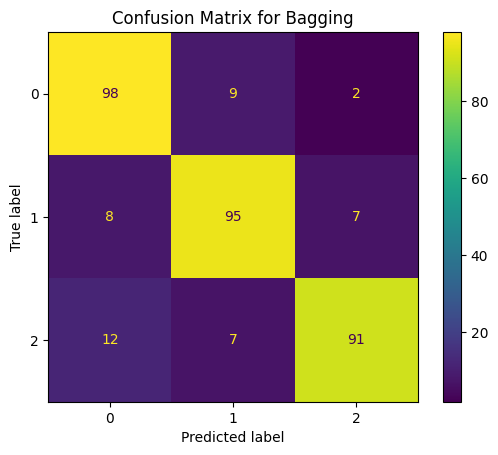

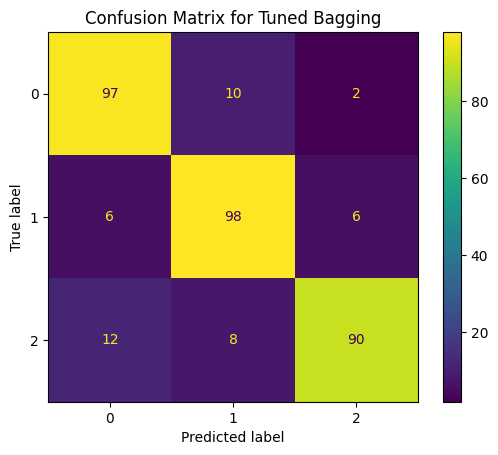

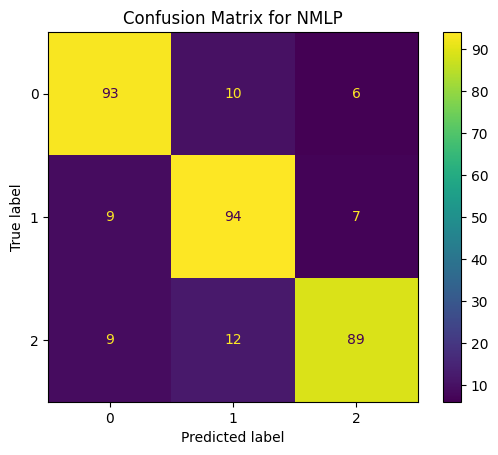

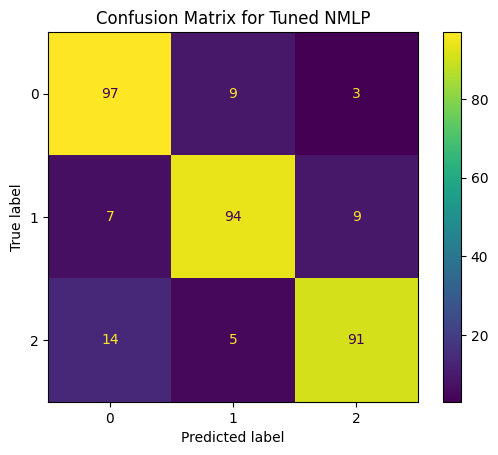

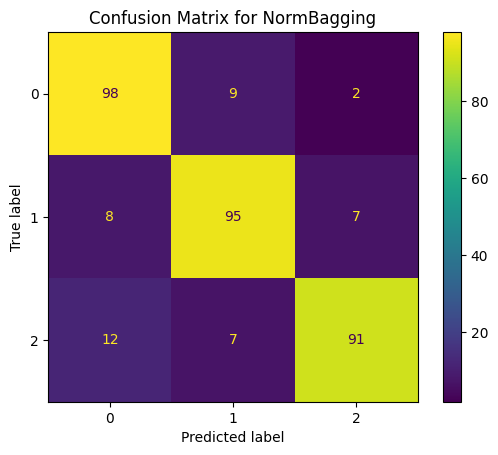

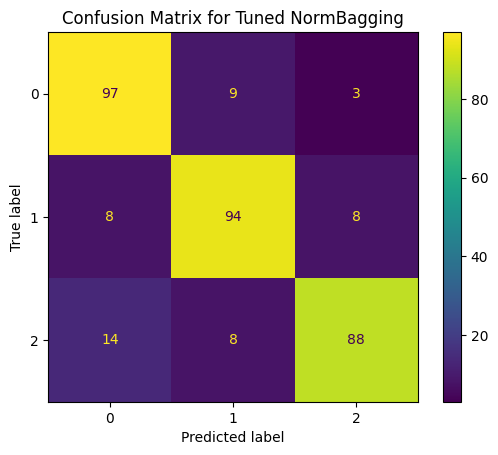

In [ ]:
plot_confusion_matrix(X_test, y_test, mlp, group="MLP")
plot_confusion_matrix(X_test, y_test, best_mlp, group="Tuned MLP")


plot_confusion_matrix(X_test, y_test, bagging, group="Bagging")
plot_confusion_matrix(X_test, y_test, best_bagging, group="Tuned Bagging")


plot_confusion_matrix(X_test, y_test, nmlp, group="NMLP")
plot_confusion_matrix(X_test, y_test, best_nmlp, group="Tuned NMLP")


plot_confusion_matrix(X_test, y_test, normBagging, group="NormBagging")
plot_confusion_matrix(X_test, y_test, best_normBagging, group="Tuned NormBagging")


In [ ]:
from plot import plot_single_model, plot_bagging_training_progress

plot_single_model(mlp, "Base MLPClassifier")
plot_bagging_training_progress(bagging, "Bagging MLPClassifier")
plot_single_model(nmlp, "Normalized MLPClassifier")
plot_bagging_training_progress(normBagging, "Normalized Bagging MLPClassifier")

plot_single_model(best_mlp, "Tuned Base MLPClassifier")
plot_bagging_training_progress(best_bagging, "Tuned Bagging MLPClassifier")
plot_single_model(best_nmlp, "Tuned Normalized MLPClassifier")
plot_bagging_training_progress(best_normBagging, "Tuned Normalized Bagging MLPClassifier")



